# Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Connect to database

In [ ]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [ ]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [ ]:
query="""
    select *
    from agg.tidy_data_30min 
    where site = 64
"""

In [ ]:
df = pd.read_sql_query(query, conn)

In [ ]:
df.info()

In [ ]:
df

In [ ]:
# Convert 'ts' to datetime and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])

df.set_index('timestamp', inplace=True)
df = df.sort_index()

df

In [ ]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (as seen in literature)

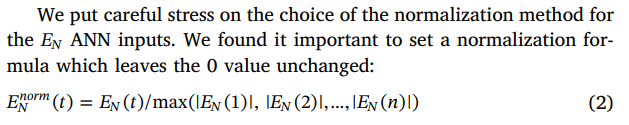



High-resolution net load forecasting for micro-neighbourhoods with high
penetration of renewable energy sources
P. Kobylinskia
, M. Wierzbowskia
, K. Piotrowskib,

In [ ]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

df

In [ ]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Prepare data set for LSTM

Example \
Based on the first 5 hours, let's predict the 6th hour\
Based on the next 5 hours, let's predict the 7th hour\
etc. etc.

[[[1], [2], [3], [4], [5]]] [6] \
[[[2], [3], [4], [5], [6]]] [7] \
[[[3], [4], [5], [6], [7]]] [8]

In [ ]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 48
# 6 hours = 2 * 6 = 12 

n_input = 48
n_features = 1
n_output = 12

# Turn net_load_norm into np array
net_load_norm = df['net_load_norm'].to_numpy().reshape(-1, 1)

X, y = [], []
for i in range(len(net_load_norm) - n_input - n_output + 1):
    X.append(net_load_norm[i:(i + n_input), 0])
    y.append(net_load_norm[(i + n_input):(i + n_input + n_output), 0])

X = np.array(X).reshape((len(X), n_input, n_features))
y = np.array(y)

In [ ]:
X.shape

In [ ]:
y.shape

First set of X and y values

In [ ]:
print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y: \n {y[0]}\n')

Second set of X and y values

In [ ]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

# Split into train (First 300 days) and test (the rest i.e., ~60 days depending on how big the n_input variable is set )

In [ ]:
# 1 time step = 30 mins

n_split = 2 * 24 * 300 

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape

In [ ]:
y_test.shape

# Build LSTM model

### Model 1

In [ ]:
model1 = Sequential()
model1.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

In [ ]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

# Fit LSTM model

In [ ]:
history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)

# Check training results

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Plot training results

In [ ]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_train_input = X_train[::n_output]
y_train_input = y_train[::n_output]

In [ ]:
X_train_input.shape

In [ ]:
y_train_input.shape

In [ ]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 1180
end_section = 1200
diff = end_section-start_section


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Training Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_train_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()

# Plot testing results

In [ ]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_test_input = X_test[::n_output]
y_test_input = y_test[::n_output]

In [ ]:
X_test_input.shape

In [ ]:
y_test_input.shape

In [ ]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 0
end_section = 10
diff = end_section-start_section


predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Testing Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_test_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()